# Feature Basic Filtering

## Purpose
Apply basic filters to remove these problematic features:
- Extremly low coverage or high coverage features
- ENCODE Blcaklist
- Some chromosomes (usually, chrY and chrM)

## Input
- Cell metadata (after basic cell filter)
- MCDS files

## Output
- FeatureList.BasicFilter.txt: List of feature ids passed all filters

## Import

In [3]:
import pandas as pd
import seaborn as sns
from ALLCools import MCDS

In [4]:
sns.set_context(context='notebook', font_scale=1.3)

## Parameters

In [6]:
# change this to the path to your filtered metadata
metadata_path = 'CellMetadata.PassQC.csv.gz'

# change this to the paths to your MCDS files
mcds_path_list = [
    '../../../data/Brain/3C-171206.mcds',
    '../../../data/Brain/3C-171207.mcds',
    '../../../data/Brain/9H-190212.mcds',
    '../../../data/Brain/9H-190219.mcds',
]

# Dimension name used to do clustering
obs_dim = 'cell'  # observation
var_dim = 'chrom100k'  # feature

min_cov = 500
max_cov = 3000

# change this to the path to ENCODE blacklist.
# The ENCODE blacklist can be download from https://github.com/Boyle-Lab/Blacklist/
black_list_path = '../../../data/genome/mm10-blacklist.v2.bed.gz'
f = 0.2

exclude_chromosome = ['chrM', 'chrY']

## Load Data

### Metadata

In [7]:
metadata = pd.read_csv(metadata_path, index_col=0)
total_cells = metadata.shape[0]
print(f'Metadata of {total_cells} cells')

Metadata of 4958 cells


In [8]:
metadata.head()

,CCC_Rate,CG_Rate,CH_Rate,FinalReads,InputReads,MappingRate,Plate,Col384,Row384,CellTypeAnno
cell,,,,,,,,,,
3C_M_0,0.00738,0.75953,0.02543,1195574.0,2896392,0.625773,CEMBA171206-3C-1,18,0,IT-L23
3C_M_1,0.00938,0.77904,0.03741,1355517.0,3306366,0.631121,CEMBA171206-3C-1,18,1,IT-L5
3C_M_10,0.00915,0.82430,0.03678,2815807.0,7382298,0.657560,CEMBA171206-3C-1,21,1,L6b
3C_M_100,0.00978,0.79705,0.04231,2392650.0,5865154,0.671600,CEMBA171206-3C-1,0,3,MGE-Pvalb
3C_M_1000,0.00776,0.78781,0.02789,1922013.0,4800236,0.646285,CEMBA171206-3C-4,3,8,IT-L6


### MCDS

In [9]:
mcds = MCDS.open(mcds_path_list, obs_dim='cell', use_obs=metadata.index)
total_feature = mcds.get_index(var_dim).size

In [10]:
mcds

<xarray.MCDS>
Dimensions:              (cell: 4958, chrom100k: 27269, count_type: 2, gene: 55487, mc_type: 2)
Coordinates:
  * mc_type              (mc_type) object 'CGN' 'CHN'
  * cell                 (cell) object '3C_M_0' '3C_M_1' ... '9H_M_3061'
  * gene                 (gene) object 'ENSMUSG00000102693.1' ... 'ENSMUSG000...
  * count_type           (count_type) object 'mc' 'cov'
    strand_type          <U4 'both'
    gene_chrom           (gene) object dask.array<chunksize=(55487,), meta=np.ndarray>
    gene_start           (gene) int64 dask.array<chunksize=(55487,), meta=np.ndarray>
    gene_end             (gene) int64 dask.array<chunksize=(55487,), meta=np.ndarray>
  * chrom100k            (chrom100k) int64 0 1 2 3 4 ... 27265 27266 27267 27268
    chrom100k_chrom      (chrom100k) object dask.array<chunksize=(27269,), meta=np.ndarray>
    chrom100k_bin_start  (chrom100k) int64 dask.array<chunksize=(27269,), meta=np.ndarray>
    chrom100k_bin_end    (chrom100k) int64 dask.array<chunksize=(27269,), meta=np.ndarray>
Data variables:
    gene_da              (cell, gene, mc_type, count_type) uint16 dask.array<chunksize=(1199, 55487, 2, 2), meta=np.ndarray>
    chrom100k_da         (cell, chrom100k, mc_type, count_type) uint16 dask.array<chunksize=(1199, 27269, 2, 2), meta=np.ndarray>

## Filter Features

### Filter by mean coverage

Feature chrom100k mean cov across cells added in MCDS.coords['chrom100k_cov_mean'].


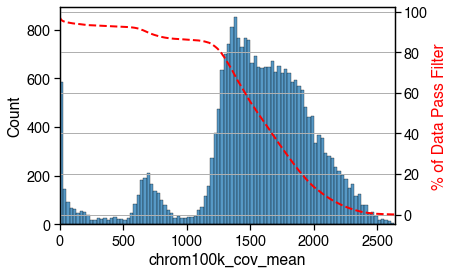

In [11]:
mcds.add_feature_cov_mean(var_dim=var_dim)

In [12]:
mcds = mcds.filter_feature_by_cov_mean(
    var_dim=var_dim,
    min_cov=min_cov,  # minimum coverage
    max_cov=max_cov  # Maximum coverage
)

Before cov mean filter: 27269 chrom100k
 After cov mean filter: 25235 chrom100k 92.5%


### Filter by ENCODE Blacklist

In [13]:
mcds = mcds.remove_black_list_region(
    var_dim,
    black_list_path,
    f=f  # Features having overlap > f with any black list region will be removed.
)

1187 chrom100k features removed due to overlapping (bedtools intersect -f 0.2) with black list regions.


### Remove chromosomes

In [14]:
mcds = mcds.remove_chromosome(var_dim, exclude_chromosome)

18 chrom100k features in ['chrM', 'chrY'] removed.


## Save Feature List

In [15]:
print(
    f'{mcds.get_index(var_dim).size} ({mcds.get_index(var_dim).size * 100 / total_feature:.1f}%) '
    f'{var_dim} remained after all the basic filter.')

24042 (88.2%) chrom100k remained after all the basic filter.


In [16]:
with open('FeatureList.BasicFilter.txt', 'w') as f:
    for var in mcds.get_index(var_dim).astype(str):
        f.write(var + '\n')